In [52]:
!pip install qsimcirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 5.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [79 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.0-arm64-cpython-310
      creating build/lib.macosx-11.0-arm64-cpython-310/qsimcirq
      copying qsimcirq/qsim_circuit.py -> build/lib.macosx-11.0-arm64-cpython-310/qsimcirq
      copying qsimcirq/__init__.py -> build/lib.macosx-11.0-arm64-cpython-310/qsimcirq
      copying qsimcirq/qsimh_simulato

In [46]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Pennylane_QAOA import Pennylane_QAOA
#from src.Bluequbit_QAOA import Bluequbit_QAOA
from src.Cirq_QAOA import Cirq_QAOA
from src.Chain import Chain
from src.Grid import Grid
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo, 
                       get_ising)
from src.Tools import get_qiskit_H

In [34]:
n_qubits = 6
init_strat = np.array([1 if i%2 == 1 else 0 for i in range(n_qubits)])
k = n_qubits // 2
my_indices = [(i, i+1) for i in range(n_qubits-1)]
n_layers = 2
alpha = 0.5
seed = 0

max_iter = 1500

In [35]:
 # Defining topology
my_chain = Chain(N_qubits=n_qubits)
my_chain.set_initialization_strategy(strategy=init_strat)

# Deciding between grid and 1d chain topology
my_topology = my_chain

# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=n_qubits, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=n_qubits,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
#full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])


if not portfolio_subspace_min_state_str == qubo_min_state_str:
    raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')

if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
    raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')

if not qubo_max_cost >= portfolio_subspace_max_cost:
    raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')

In [36]:
qiskit_ansatz = QAOA(N_qubits=n_qubits,
                     layers=n_layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset,
                     constraining_mixer=False,
                     Topology=my_topology)

pennylane_ansatz = Pennylane_QAOA(N_qubits=n_qubits,
                                  layers=n_layers,
                                  QUBO_matrix=Q,
                                  QUBO_offset=offset)

"""bluequbit_ansatz = Bluequbit_QAOA(N_qubits=n_qubits,
                                  layers=n_layers,
                                  QUBO_matrix=Q,
                                  QUBO_offset=offset)"""

cirq_ansatz = Cirq_QAOA(N_qubits=n_qubits,
                                  layers=n_layers,
                                  QUBO_matrix=Q,
                                  QUBO_offset=offset)

In [37]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[0]

# Generating callback function for plotting
qiskit_costs = [] # Normalized costs
qiskit_probs = [] # probability of optimal state
def qiskit_callback(x):
    _dict_ = qiskit_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        qiskit_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        qiskit_probs.append(0)
    qiskit_costs.append(_cost_)
    
# Generating callback function for plotting
pennylane_costs = [] # Normalized costs
pennylane_probs = [] # probability of optimal state
def pennylane_callback(x):
    _dict_ = pennylane_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        pennylane_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        pennylane_probs.append(0)
    pennylane_costs.append(_cost_)
    

"""# Generating callback function for plotting
bluequbit_costs = [] # Normalized costs
bluequbit_probs = [] # probability of optimal state
def bluequbit_callback(x):
    _dict_ = bluequbit_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        bluequbit_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        bluequbit_probs.append(0)
    bluequbit_costs.append(_cost_)"""


# Generating callback function for plotting
cirq_costs = [] # Normalized costs
cirq_probs = [] # probability of optimal state
def cirq_callback(x):
    _dict_ = cirq_ansatz.get_state_probabilities(flip_states=False)
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        cirq_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        cirq_probs.append(0)
    cirq_costs.append(_cost_)

# Generating initial guess for rotation angles
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = 2 * n_layers
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

In [38]:
qiskit_res = sc.optimize.minimize(fun=qiskit_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter},
                                  callback=qiskit_callback)
qiskit_res


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4448843442124757
       x: [ 1.877e+00  1.376e+00  9.955e-01  1.388e+00]
    nfev: 959
   maxcv: 0.0

In [39]:
pennylane_res = sc.optimize.minimize(fun=pennylane_ansatz.get_cost, 
                                     x0=theta_i,
                                     method=optimizer_method,
                                     options={'disp': False, 
                                               'maxiter': max_iter},
                                     callback=pennylane_callback)
pennylane_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.5151519640447131
       x: [ 1.524e+00  1.868e+00  1.239e+00  3.840e-01]
    nfev: 169
   maxcv: 0.0

In [40]:
"""bluequbit_res = sc.optimize.minimize(fun=bluequbit_ansatz.get_cost, 
                                     x0=theta_i,
                                     method=optimizer_method,
                                     options={'disp': False, 
                                               'maxiter': max_iter},
                                     callback=bluequbit_callback)
bluequbit_res"""

"bluequbit_res = sc.optimize.minimize(fun=bluequbit_ansatz.get_cost, \n                                     x0=theta_i,\n                                     method=optimizer_method,\n                                     options={'disp': False, \n                                               'maxiter': max_iter},\n                                     callback=bluequbit_callback)\nbluequbit_res"

In [41]:
cirq_res = sc.optimize.minimize(fun=cirq_ansatz.get_cost, 
                                     x0=theta_i,
                                     method=optimizer_method,
                                     options={'disp': False, 
                                               'maxiter': max_iter},
                                     callback=cirq_callback)
cirq_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4905712756328876
       x: [ 1.372e+00  2.793e+00  1.294e+00  5.724e-01]
    nfev: 373
   maxcv: 0.0

In [42]:
qiskit_ansatz.circuit_time, qiskit_ansatz.cost_time

(4.892102479934692, 0.13191461563110352)

In [43]:
pennylane_ansatz.circuit_time, pennylane_ansatz.cost_time

(0.873084545135498, 0.029922008514404297)

In [44]:
#bluequbit_ansatz.circuit_time, bluequbit_ansatz.cost_time

In [45]:
cirq_ansatz.circuit_time, cirq_ansatz.cost_time

(3.6876158714294434, 0.053924560546875)

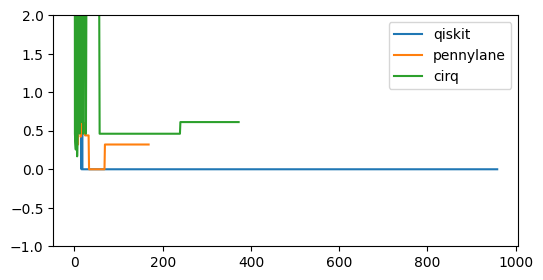

In [51]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.plot([it for it in range(len(qiskit_costs))], qiskit_costs, label='qiskit')
ax.plot([it for it in range(len(pennylane_costs))], pennylane_costs, label='pennylane')
ax.plot([it for it in range(len(cirq_costs))], cirq_costs, label='cirq')
ax.legend()
ax.set_ylim(-1,2)
plt.show()